<a href="https://colab.research.google.com/github/ashmitamittal/NLP-Models-Playground/blob/main/vector_index_neo4j.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[NEO4J X LANFCHAIN](https://bratanic-tomaz.medium.com/neo4j-x-langchain-deep-dive-into-the-new-vector-index-implementation-3bd79601cd2)

Testing out the new vector index by NEO4J using openAI

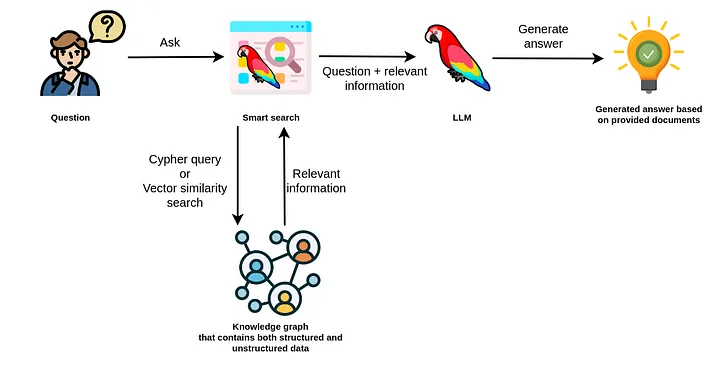

In [ ]:
!pip install langchain wikipedia tiktoken neo4j openai


**How Vector Index Works for Searches**:
- Imagine you have a query (like a sentence or a paragraph), and you want to find the most relevant or similar text chunks in your database. This query is first converted into a vector using the same method as your stored text chunks.

```
                  QUERY → CHUNKS → VECTOR
```
- The vector index then rapidly compares this query vector against all the vectors in the index to find the ones with the highest similarity. This is much faster than comparing the query with every single text chunk without an index.

In [ ]:
import os

from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.document_loaders import WikipediaLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document

os.environ["OPENAI_API_KEY"]= "ENTER_KEY_HERE"

## Loading the data
The code uses WikipediaLoader to fetch data from Wikipedia and then splits the text into chunks using CharacterTextSplitter. This process prepares the data for being indexed in Neo4j.



In [ ]:
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import CharacterTextSplitter

# Read the wikipedia article
raw_documents = WikipediaLoader(query="The Witcher").load()

# Define chunking strategy
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=20
)
# Chunk the document
documents = text_splitter.split_documents(raw_documents)
# Remove the summary
for d in documents:
    del d.metadata["summary"]


# Neo4j Vector index customization
Each text chunk is stored as a node in Neo4j.
node label = WikipediaArticle

## Neo4j Vector Index and what each of the keys in the code snippet does:

1. **`index_name="wikipedia"`**:
    - This specifies the name of the vector index being created in Neo4j. By default, it's named `vector`, but in this example, it's been renamed to `wikipedia`. This name is used when you want to query or reference this specific vector index later.
2. **`node_label="WikipediaArticle"`**:
    - This is the label assigned to each node (or data entry) in the Neo4j database. By default, nodes are labeled `Chunk`, but here it's customized to `WikipediaArticle`. This label helps in organizing and querying data.
3. **`text_node_property="info"`**:
    - Each node in Neo4j can have various properties (like fields in a database). By default, the property holding the text content of the node is named `text`. In this example, it's been changed to `info`. So, for each `WikipediaArticle` node, the actual text from the Wikipedia article is stored in the `info` property.
4. **`embedding_node_property="vector"`**:
    - This is similar to `text_node_property` but for the vector representation of the text. By default, this property is named `embedding`, but here it's named `vector`. This property stores the numerical vector that represents the text content, which is used for similarity searches.
5. **`create_id_index=True`**:
    - This is a boolean value (True/False). When set to True, it creates an index on the `id` property of each node. An index on `id` makes it faster to find and query nodes based on their unique identifier. It's like having an efficient lookup system for the nodes based on their IDs.

In [ ]:
neo4j_db = Neo4jVector.from_documents(
    documents,
    OpenAIEmbeddings(),
    url="ENTER_URL",
    username="neo4j",
    password="ENTER_PASS",
    database="neo4j",  # neo4j by default
    index_name="wikipedia",  # vector by default
    node_label="WikipediaArticle",  # Chunk by default
    text_node_property="info",  # text by default
    embedding_node_property="vector",  # embedding by default
    create_id_index=True,  # True by default
)


In [ ]:
neo4j_db.query("SHOW CONSTRAINTS")

[{'id': 5,
  'name': 'constraint_e5da4d45',
  'type': 'UNIQUENESS',
  'entityType': 'NODE',
  'labelsOrTypes': ['WikipediaArticle'],
  'properties': ['id'],
  'ownedIndex': 'constraint_e5da4d45',
  'propertyType': None}]

In [ ]:
neo4j_db.query(
    """SHOW INDEXES
       YIELD name, type, labelsOrTypes, properties, options
       WHERE type = 'VECTOR'
    """
)


[{'name': 'wikipedia',
  'type': 'VECTOR',
  'labelsOrTypes': ['WikipediaArticle'],
  'properties': ['vector'],
  'options': {'indexProvider': 'vector-1.0',
   'indexConfig': {'vector.dimensions': 1536,
    'vector.similarity_function': 'cosine'}}}]

# loading additional docs

In [ ]:
neo4j_db.add_documents(
    [
        Document(
            page_content="LangChain is the coolest library since the Library of Alexandria",
            metadata={"author": "Ashmita", "confidence": 1.0}
        )
    ],
    ids=["langchain"],
)


['langchain']

# loading existing index

In [ ]:
existing_index = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(),
    url="ENTER_URL",
    username="neo4j",
    password="ENTER_PASS",
    index_name="wikipedia",
    text_node_property="info",  # Need to define if it is not default
)


In [ ]:
print(existing_index.node_label)
print(existing_index.embedding_node_property)


WikipediaArticle
vector


# custom retrieval queries
1. **What is a Retrieval Query?**
    - In Neo4j, a retrieval query is a command you write to fetch (or "retrieve") specific data from the database. You use Neo4j's query language, Cypher, to specify what you want to find and bring back from the database.
2. **Custom Retrieval Queries in the Context of Vector Indexes**:
    - Normally, when you do a search using the vector index, it returns nodes (text chunks) that are most similar to your search query. But sometimes, you want more than just the text chunk; you might want extra information related to that chunk. This is where custom retrieval queries come in.
    - These queries are "custom" because you write them to get not just the text chunk, but also additional details like who wrote the chunk, when it was written, or any other related data you have in your database.
3. **Example Simplified**:
    - Imagine you have a database of book excerpts. Each excerpt (text chunk) is a node in Neo4j.
    - You search for excerpts similar to a sentence you like. The vector index helps you find these similar excerpts.
    - But you also want to know which book each excerpt is from and the author's name. Here, a custom retrieval query can be programmed to fetch this extra information (book title, author's name) along with the excerpts.
    - So, instead of just getting a list of similar texts, you get a list of similar texts with extra useful details.
4. **How It's Done**:
    - You write a Cypher query that not only fetches the similar text chunks but also "joins" (or connects) these chunks with other related data in your database.
    - This could mean linking a text chunk node to another node that contains its author's information or any other related metadata.

In [26]:
existing_index.query(
    """MATCH (w:WikipediaArticle {id:'langchain'})
       MERGE (w)<-[:EDITED_BY]-(:Person {name:"Galileo"})
    """
)


[]

In [27]:
retrieval_query = """
OPTIONAL MATCH (node)<-[:EDITED_BY]-(p)
WITH node, score, collect(p) AS editors
RETURN node.info AS text,
       score,
       node {.*, vector: Null, info: Null, editors: editors} AS metadata
"""

existing_index_return = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(),
    url="ENTER_URL",
    username="neo4j",
    password="ENTER_PASS",
    database="neo4j",
    index_name="wikipedia",
    text_node_property="info",
    retrieval_query=retrieval_query,
)


In [ ]:
existing_index_return.similarity_search("What do you know about LangChain?", k=1)


[Document(page_content='LangChain is the coolest library since the Library of Alexandria', metadata={'id': 'langchain', 'author': 'Ashmita', 'editors': [{'name': 'Galileo'}], 'confidence': 1.0})]